In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

import sys
import torch
from data import datasets
from data.chembldb import ChemblDBIndications
from training import trainer
from modules import ind_generator
from analysis import similarity

import plots, utilities
from IPython.display import display, Markdown
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pathlib


## Lets begin by loading the dataset

The CharSMILESChEMBLIndications dataset contains smiles strings associated with their drug indications (i.e. what diseases or conditions they are able to treat)

In [3]:
preprocessed_fn = "CharSmilesPreprocessed.csv"

if not pathlib.Path.exists(pathlib.Path(preprocessed_fn)):
    raw_data = ChemblDBIndications()._load_data()
    preprocessed = ChemblDBIndications()._preprocess(raw_data, max_length=512, save_path=preprocessed_fn)

Preprocessing


In [4]:

dataset = datasets.CharSMILESChEMBLIndications(
    all_data=pd.read_csv(preprocessed_fn),
    batch_size=128
)

## What are some of the most common indications in our dataset

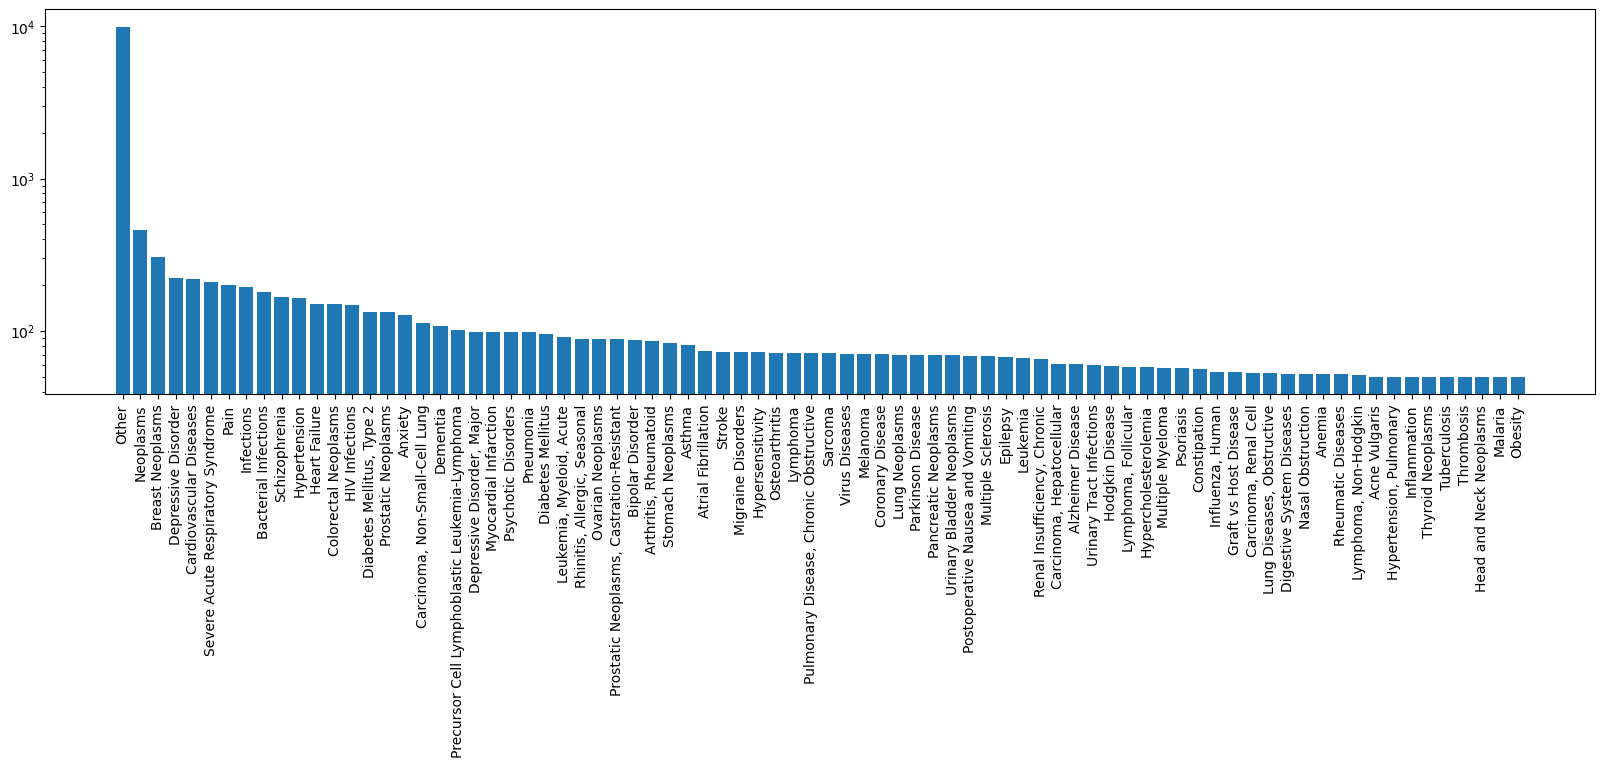

In [6]:
most_frequent_indications = dataset.all_data.drop(columns=["canonical_smiles"]).sum(axis=0).sort_values(ascending=False)
most_frequent_indications_names = most_frequent_indications.index.to_list()
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 5))
ax.bar(np.arange(len(most_frequent_indications)), most_frequent_indications.to_numpy())
ax.set_xticks(np.arange(len(most_frequent_indications)))
labels = ax.set_xticklabels([heading.replace("mesh_heading_", "") for heading in most_frequent_indications.index], rotation=90)
ax.set_yscale("log")

## What do the molecules look like for our most common indication?

## Showing 9 example chemical structures for mesh_heading_Other

rows=3, cols=3


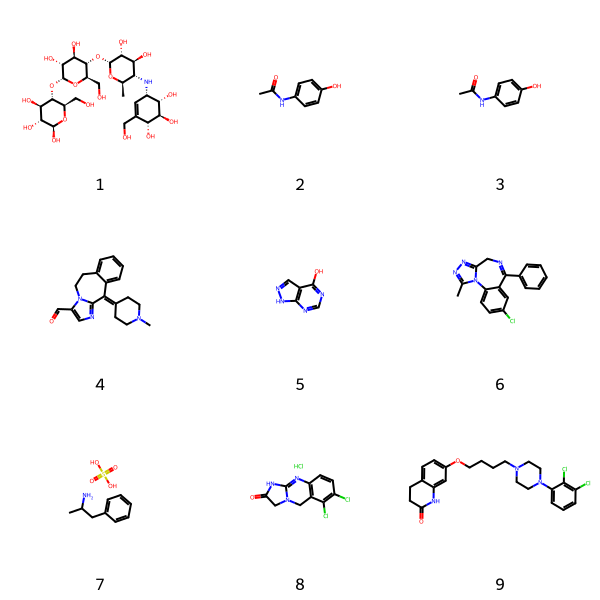

## Showing 9 example chemical structures for mesh_heading_Neoplasms

rows=3, cols=3


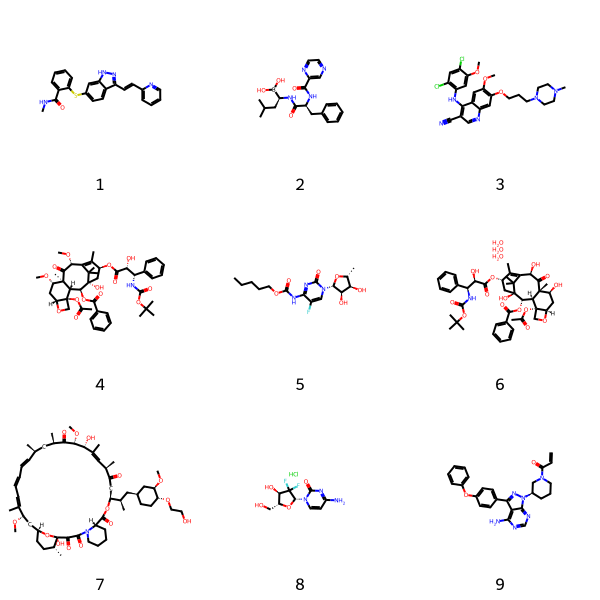

## Showing 9 example chemical structures for mesh_heading_Breast Neoplasms

rows=3, cols=3


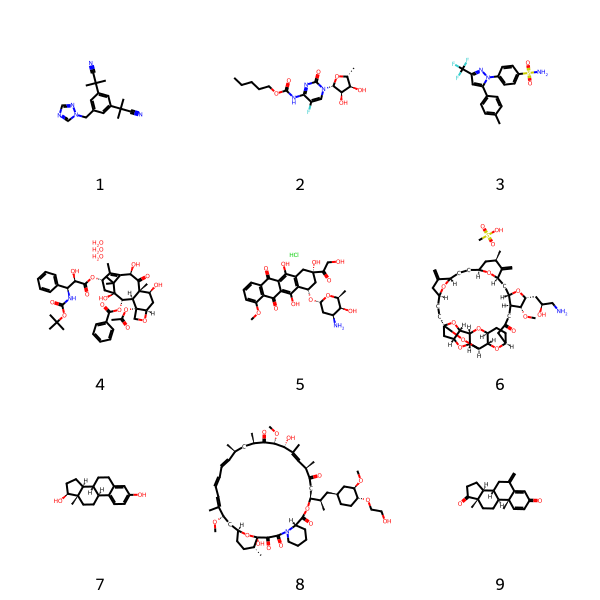

## Showing 9 example chemical structures for mesh_heading_Depressive Disorder

rows=3, cols=3


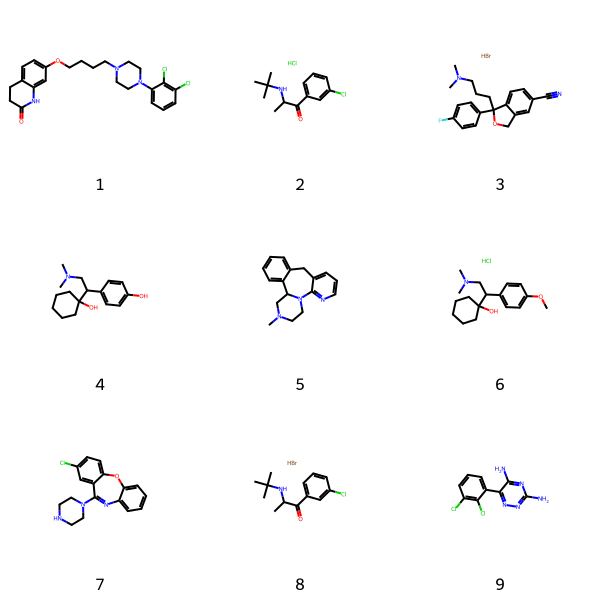

## Showing 9 example chemical structures for mesh_heading_Cardiovascular Diseases

rows=3, cols=3


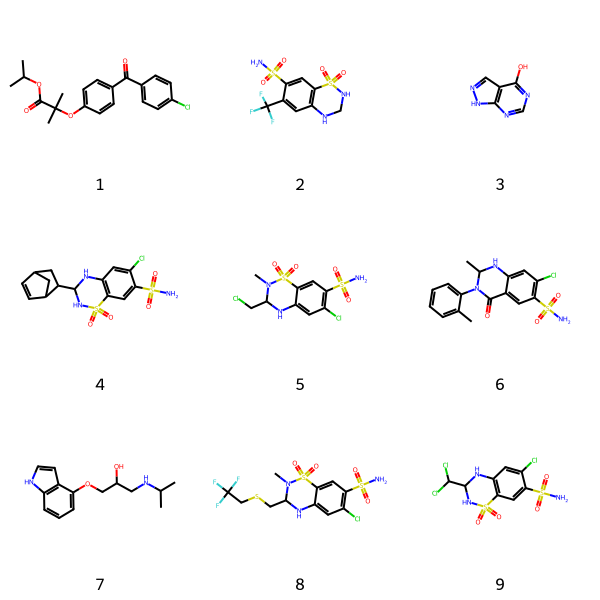

## Showing 9 example chemical structures for mesh_heading_Severe Acute Respiratory Syndrome

rows=3, cols=3


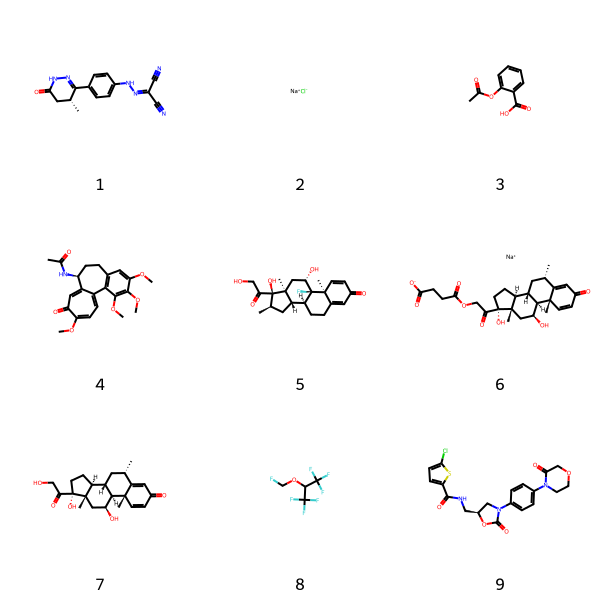

## Showing 9 example chemical structures for mesh_heading_Pain

rows=3, cols=3


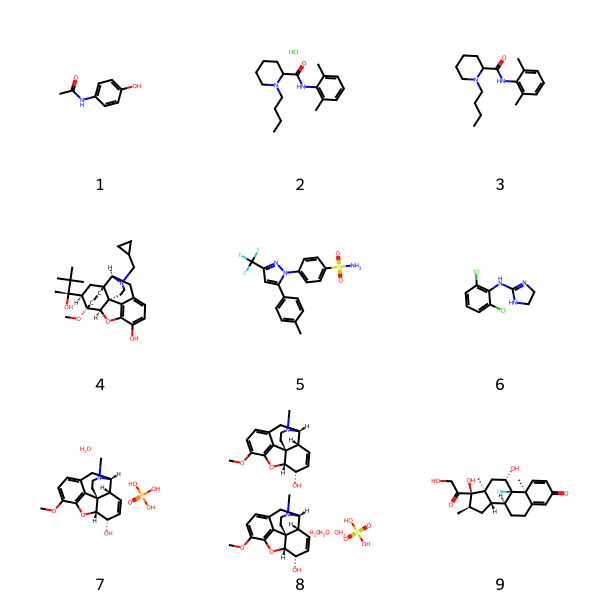

## Showing 9 example chemical structures for mesh_heading_Infections

rows=3, cols=3


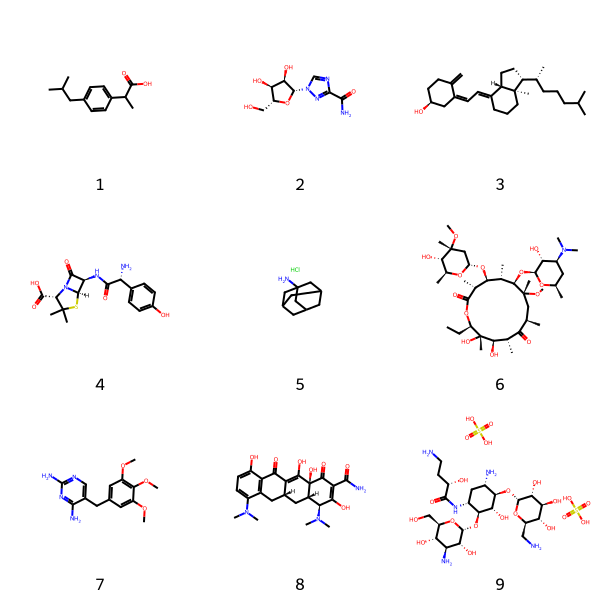

## Showing 9 example chemical structures for mesh_heading_Bacterial Infections

rows=3, cols=3


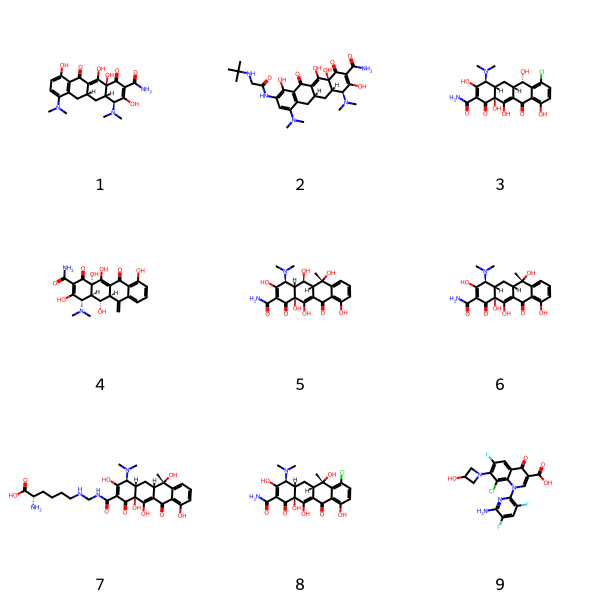

## Showing 9 example chemical structures for mesh_heading_Schizophrenia

rows=3, cols=3


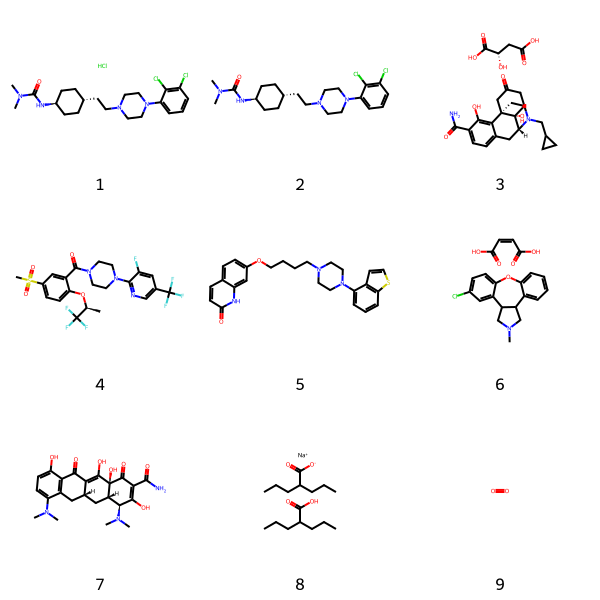

In [7]:
images_per_indication = 9  # Visualise a 3x3 grid of drug molecules

for indications_filter_index in range(10):
    # indications_filter_index = 1
    indications_filter_name = most_frequent_indications.index[indications_filter_index]
    filtered_molecules = dataset.all_data.filter(items=["canonical_smiles", indications_filter_name])
    filtered_molecules = filtered_molecules[filtered_molecules[indications_filter_name]].drop(columns=[indications_filter_name])
    filtered_molecules = filtered_molecules.rename(columns={"canonical_smiles": indications_filter_name})

    smiles_to_draw = [smiles for smiles in filtered_molecules[indications_filter_name][:images_per_indication]]

    display(Markdown(f"## Showing {images_per_indication} example chemical structures for {indications_filter_name}"))
    display(
        utilities.draw_molecules_as_grid_from_smiles(
            canonical_smiles=smiles_to_draw, 
            names=[str(i + 1) for i in range(images_per_indication)]  # Just number them
        )
    )

In [6]:
indications_filter_name

'Unnamed: 0'

# Model training

In [ ]:
config = ind_generator.SmilesIndGeneratorRNNConfig(
    vocab_size = len(dataset.vocab),
    num_indications = dataset.num_indications,
    num_hiddens = 256,
    num_layers = 4,
    learning_rate = 1e-3,
    weight_decay = 1e-5,
    output_dropout = 0.4,
    rnn_dropout = 0.4,
    state_dropout = 0.4
)

# Produces pretty bad models, but fine for debugging.
config_mini = ind_generator.SmilesIndGeneratorRNNConfig(
    vocab_size = len(dataset.vocab),
    num_indications = dataset.num_indications,
    num_hiddens = 64,
    num_layers = 5,
    learning_rate = 1e-3,
    weight_decay = 1e-5,
    output_dropout = 0.4,
    rnn_dropout = 0.4,
    state_dropout = 0.4
)

model = ind_generator.SmilesIndGeneratorRNN(config)

In [ ]:

load_model_path = "../models/Chembl-Ind-SmilesIndGeneratorRNN-CharSMILESChEMBLIndications-2025-07-31-08-01-18.pt"

train_new = True  # Set false to load a pre-trained model
save_model = True  # If trainign a new model, do we want to save it?

if train_new:
    model_trainer = trainer.Trainer(max_epochs=64, init_random=None, clip_grads_norm=10.0)
    model_trainer.fit(model, dataset)

    if save_model:
        utilities.save_model_weights("Chembl-Ind-", model, dataset)
else: 
    model.load_state_dict(
        state_dict= torch.load(load_model_path, weights_only=True),
    )
    device="cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

In [ ]:
if train_new:
    losses = utilities.extract_training_losses(model_trainer.metadata)
    fig, ax = plots.plot_training_validation_loss(
        training_losses = losses['avg_train_losses'], 
        validation_losses = losses['avg_val_losses']
    )
    ax.set_yscale('log')

In [ ]:
test_batch = dataset[20]

output, _ = model((test_batch[0].unsqueeze(0).to(device="cuda"), test_batch[1].unsqueeze(0).to(device="cuda")))

print(output)

print(f"(Seq Len, vocab size): {test_batch[0].shape}, (Indications): {test_batch[1].shape}, (Seq Len): {test_batch[2].shape}")
print(f"Input SMILES: {dataset.vocab.decode_tokens(test_batch[2].cpu().numpy())}")

print(f"Prediction: {dataset.vocab.decode_tokens(output.argmax(dim=-1).squeeze().cpu().numpy())}")
print(f"Prediction Encoded: {output.argmax(dim=-1).squeeze().cpu().numpy()}")

# Example usage: generating molecules for a particular indication

In [ ]:
# Define a quick convenience function which will let us generate a sample of molecules for a particul indication

def generate_samples(rows, cols,  dataset, model, prompt, indication_name, max_attempts, max_generate, temperature):
    rows, cols = 5, 5

    n_valid = 0
    n_invalid = 0
    outputs = []

    mesh_indices = [dataset.indications_names.index(indication_name)] * (rows * cols)

    # We don't always get valid output, so we use a robust generation procedure to allow us to make a few
    # Attempts at getting a valid output
    max_attempts = 10
    for idx in mesh_indices:

        output = utilities.robust_generate(
            utilities.simple_generate,
            max_attempts=max_attempts,
            prefix=prompt,
            model=model,
            vocab=dataset.vocab,
            init_state_tensor = dataset.get_indications_tensor(dataset.indications_names[idx]).unsqueeze(0).to("cuda"),
            max_generate=max_generate,
            temperature=temperature,
            device="cuda" if torch.cuda.is_available() else "cpu"
        )

        # Throw a warning if this exact output is in the training set
        if output in dataset.all_data["canonical_smiles"].tolist():
            print("\n WARNING: Exact output found in training. \n")

        if output:
            outputs.append(output)
            n_valid += 1
        if not output:
            n_invalid += 1
            print("Generated SMILES is not valid.")
            outputs.append(None)

    return outputs

## Example 1: Generating antibiotics (mesh heading: Infections, or Bacterial Infections)

### We generate an array of molecules which bear similarity to macrocyline, anthracycline and beta-lactam derived antibiotics.

In [ ]:
# indication = "mesh_heading_Infections"
indication = "mesh_heading_Bacterial Infections"
indication_name = indication.replace("mesh_heading_", "")
outputs = generate_samples(
    rows=5,
    cols=5,
    dataset=dataset,
    model=model,
    prompt=dataset.vocab.bos.char, # Prompt is just the beginning of sentence special character
    indication_name=indication,
    max_attempts=10,
    max_generate=100,
    temperature=0.9
)

display(
    Markdown(f"## {indication_name}")
)
display(
    utilities.draw_molecules_as_grid_from_smiles(
        canonical_smiles=outputs, 
        names=[indication_name] * len(outputs)  
    )
)

## To generate examples of molecules for treating pain, we just specify the mesh heading.

In [ ]:
# Specify mesh heading
indication = "mesh_heading_Pain"


indication_name = indication.replace("mesh_heading_", "")
outputs = generate_samples(
    rows=5,
    cols=5,
    dataset=dataset,
    model=model,
    prompt=dataset.vocab.bos.char, # Prompt is just the beginning of sentence special character
    indication_name=indication,
    max_attempts=10,
    max_generate=100,
    temperature=0.9
)

display(
    Markdown(f"## {indication_name}")
)
display(
    utilities.draw_molecules_as_grid_from_smiles(
        canonical_smiles=outputs, 
        names=[indication_name] * len(outputs)  
    )
)

## Or if we'd like to generate drugs for treating cardiovascular diseases derived from sulfamethoxazole, we can supply a fragment of sulfamethoxazole as a prompt.

In [ ]:
# Specify mesh heading
indication = "mesh_heading_Cardiovascular Diseases"


indication_name = indication.replace("mesh_heading_", "")
outputs = generate_samples(
    rows=5,
    cols=5,
    dataset=dataset,
    model=model,
    prompt="<CC1=CC(=NO1)NS(=O)(=O)C",
    indication_name=indication,
    max_attempts=10,
    max_generate=100,
    temperature=0.7,
)

display(
    Markdown(f"## {indication_name}")
)
display(
    utilities.draw_molecules_as_grid_from_smiles(
        canonical_smiles=outputs, 
        names=[indication_name] * len(outputs)  
    )
)

## Increasing the temperature lets us control the diversity of the molecules generated.

In [ ]:
# Specify mesh heading
indication = "mesh_heading_Cardiovascular Diseases"


indication_name = indication.replace("mesh_heading_", "")
outputs = generate_samples(
    rows=5,
    cols=5,
    dataset=dataset,
    model=model,
    prompt="<CC1=CC(=NO1)NS(=O)(=O)C",
    indication_name=indication,
    max_attempts=10,
    max_generate=100,
    temperature=1.3,
)

display(
    Markdown(f"## {indication_name}")
)
display(
    utilities.draw_molecules_as_grid_from_smiles(
        canonical_smiles=outputs, 
        names=[indication_name] * len(outputs)  
    )
)

In [ ]:
# # Fun outputs:

# Crazy triple macrocycle
#  'N[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=O)C(=O)N[C@H]2C(=O)N[C@H]3C(=O)N[C@H](C(=O)N[C@H](C(=O)O)c4cc(O)cc(O)c4-c4cc3ccc4O)[C@H](O)c3ccc(c(Cl)c3)Oc3cc2cc(c3O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O[C@H]2C[C@](C)(N)[C@H](O)[C@H](C)O2)Oc2ccc(cc2Cl)[C@H]1O',

# Amino acid macrocycle, containing cysteine disulfide bridge
# 'C(C)[C@@H]1NC(=O)[C@H](CCCCN)NC(=O)[C@@H](Cc2c[nH]c3ccccc23)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H](NC(=O)[C@H](N)Cc2ccccc2)CSSC[C@@H](C(=O)N[C@H](CO)[C@@H](C)O)NC1=O',

# Prompt to Generate variants of macrocycles: 
#  C[C@H]1OC(=O)[C@H](C)[C@@H](O


## We can visualise our molecules in 3D for closer inspection.

In [ ]:
view = utilities.visualise_3d_molecule_from_smiles(outputs[3])
view